## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1')['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# Count items in the same group and landing page and 
# sum up the numbers of user_id where new_page and treatment or control and old_page don't match
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [7]:
# Alternatively, make a query and then count numbers of user_id
df.query('(group == "treatment" and landing_page != "new_page") or \
         (group != "treatment" and landing_page == "new_page")').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

**So the number of times the** `new_page` **and** `treatment` **don't match is 3893.**

f. Do any of the rows have missing values?

In [8]:
# See info of df if total numbers of each column are equal to entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**Because the numbers of non-null in each coloumn are equal to 294478 entries, we could be sure that no row has missing values.**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications. Store your new dataframe in **df2**.

In [9]:
# Index rows where treatment does not match with new_page
# or control does not match old_page
boo = ((df['group'] == "treatment") & (df['landing_page'] != "new_page"))\
    |((df['group'] == "control") & (df['landing_page'] != "old_page"))
idx = df[boo].index

In [10]:
# Drop the rows
df2 = df.drop(idx)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# Find the user_id of the duplicated user
dup_user = df2[df2['user_id'].duplicated()]['user_id'].values[0]
dup_user

773192

c. What is the row information for the repeat **user_id**? 

In [14]:
df2.query('user_id == @dup_user')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates('user_id', inplace=True)

# Check if one duplicated row was dropped
df2.query('user_id == @dup_user')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control_converted = df2.query('group == "control"')['converted'].mean()
p_control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treatment_converted = df2.query('group == "treatment"')['converted'].mean()
p_treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
(df2['landing_page'] == "new_page").mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The results even show less conversion for the new treatment. However, there is still not sufficient evidence to make the conclusion since this is the results of collected data that is only subset of population (descriptive statistic). Sampling distribution of sample means and hypothesis test are the keys to draw conclusions from collected data to represent population (inferential statistic).**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_0 : p_{new} - p_{old} \le 0 \\
H_1 : p_{new} - p_{old} > 0$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2.query('landing_page =="new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query('landing_page =="old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1],size = n_new, p = [1-p_new,p_new])
new_page_converted.mean()

0.11992292340513386

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [1-p_old,p_old])
old_page_converted.mean()

0.11881685642303509

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.0011060669820987662

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []

for _ in range(int(1e4)):
    new_page_converted = np.random.choice([0,1],size = n_new, p = [1-p_new,p_new],replace=True)
    old_page_converted = np.random.choice([0,1], size = n_old, p = [1-p_old,p_old],replace=True)
    p_diffs.append( new_page_converted.mean() - old_page_converted.mean())
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [28]:
# Convert p_diffs to arrays
p_diffs = np.array(p_diffs)

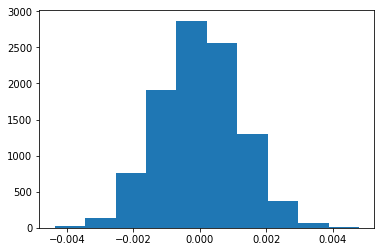

In [29]:
# Plot histogram to see the distribution of p_diffs
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# Actual conversions in case of old and new pages
p_new_converted = df2.query('landing_page == "new_page"')['converted'].mean()
p_old_converted = df2.query('landing_page == "old_page"')['converted'].mean()
obs_diff = p_new_converted - p_old_converted

# Proportion of p_diffs greater than obs_diff
(p_diffs > obs_diff).mean()

0.902

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**To reject the null hypothesis that the new page is not better than the old page, the probability that null hypothesis is true (p-value) should be less than the confidence interval of 5 %. Therefore, this hypothesis test shows that we fail to reject the null hypothesis becuase p-value is 0.9 (a lot more than 0.05!!).**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted ==1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted ==1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
from statsmodels.stats.proportion import proportions_ztest

z_score, p_val = proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger')
z_score, p_val

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score here is -1.31, which means the observed difference is less than mean of 0 (p_new - p_old =0). The p-value of 0.9 is in good agreement with the value calculated previously. In conclusion, conversion rate of new page is not better than the old page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression should be performed in this case where dependent variable is categorical.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
# Create dummies for categorical variable 'group'
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

# Add intercept conlumn
df2['intercept'] = 1

df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
model1 = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result1 = model1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        22:35:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**P-value associated with ab_page shows how statistically significant ab_page is to the conversion. That is, when ab_page has a large p-value, there is no correlation between landing_page and the conversion rate meaning no difference between $p_{old}$ and $p_{new}$. Unlike a one-tailed hypothesis test for A/B testing in PartII, the hypothesis test for the regression model can be written as a two-tailed test:**

$H_0: p_{old} = p_{new} \\
H_1: p_{old} \ne p_{new}$

**Since p-value in this case is larger than 0.05 (when significance interval is 95%), it means ab_page variable is not statistically significant.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to consider other factors to add in the regression model because the ab_page is the only one variable taken into account in the model and the result of p-value shows that it does not have statistical significance to the conversion.**

**By adding too many additional terms into the regression model, new variables may not have significant coefficience and mislead interpretation of other variables. One example of having too many variables is collienearity effect, which happens when there is linear relationship between some variables.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [36]:
# Import data
df_countries = pd.read_csv('countries.csv')

# Show first few rows in dataframe
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# See values in column 'country'
df_countries['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [38]:
# Join df_countries to df2 on 'user_id'
df2 = df2.join(df_countries.set_index('user_id'), on='user_id')

# Show first few rows in df2 after joining
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [39]:
# Create dummies for column 'country'
df2 = df2.join(pd.get_dummies(df2['country']))

# Show first few rows in df2 after joining
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [40]:
# Fit logistic model using 'CA' as a baseline
model2 = sm.Logit(df2['converted'],df2[['intercept','ab_page','UK','US']])
result2 = model2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 03 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        22:36:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**The result shows that non of the variables have statistical significance to the conversion because p-values are higher than 0.05. Possibly, the ab_page is related to the conversion depending on countries. In this case, interaction terms between page and country should be taken into account.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
# Using 'CA' as baseline, now add columns for interaction of country and ab_page
df2['ab_UK'] = df2['ab_page']*df2['UK']
df2['ab_US'] = df2['ab_page']*df2['US']

# Show first few rows in df2 after adding columns
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,ab_UK,ab_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0


In [42]:
# Fit logistic model
model3 = sm.Logit(df2['converted'],df2[['intercept','ab_page','UK','US','ab_UK','ab_US']])
result3 = model3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 03 May 2019   Pseudo R-squ.:               3.482e-05
Time:                        22:36:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**The result shows that variables 'UK' and 'US' alone are not statistically significant since p-values of these two variables are relatively higher than the others. Now we should try eliminating these variables in the next model.**

In [43]:
# Fit logistic model without 'UK' and 'US'
model4 = sm.Logit(df2['converted'],df2[['intercept','ab_page','ab_UK','ab_US']])
result4 = model4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 03 May 2019   Pseudo R-squ.:               3.351e-05
Time:                        22:36:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0827      0.038     -2.176      0.030      -0.157      -0.008
ab_UK          0.0901      0.040      2.225      0.026       0.011       0.169
ab_US          0.0644      0.038      1.679      0.093      -0.011       0.140
==============================================================================
"""

In [44]:
# Exponentiate the coefficients
np.exp(-1.9888),np.exp(0.0827),np.exp(0.0901),np.exp(0.0644)

(0.13685955841614492,
 1.086215894895166,
 1.0942837066046347,
 1.0665189210197745)

**Now the result shows that ab_page has statistical significant to the conversion depending on country. With 'CA' as the baseline, it shows that ab_page in 'UK' increase the conversion by 1.09 times and by 1.07 in 'US'. In addition, ab_test in UK is more significant than in US.**

<a id='conclusions'></a>
## Finishing Up

> **The A/B test run by an e-commerce website shows that the new page is not better than the old page on the conversion of the overall customers.Therefore, the old page should be kept. However, by regression appraoch, A/B test is statistical significant to the conversion in UK.**
